# CNNによる画像分類

画像分類とは、画像の種類や状態を定量的に解析して特定のクラスに分類するタスクである。  
ここでは、細胞画像を生細胞と死細胞に分類するタスクを学習するためのCNNを構築し、訓練および評価までの一連の作業を行う。

## データセット

`dataset_cls/` にHeLa細胞の位相差顕微鏡画像300枚 (生細胞150枚, 死細胞150枚) が格納されている。  
画像サイズはすべて 128x128 pixel で、グレースケール画像となっている。  

まず最初に画像を読み込み表示してみる。

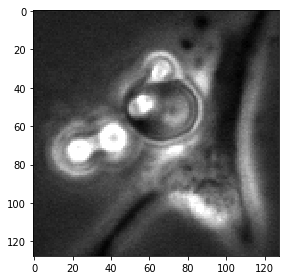

In [7]:
import skimage.io as io

%matplotlib inline
img_live = io.imread('../datasets/dataset_cls/live/001.tif')
io.imshow(img_live)

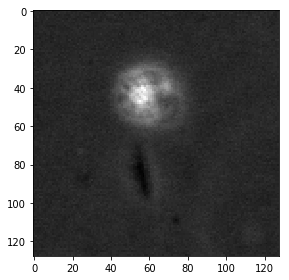

In [8]:
img_dead = io.imread('../datasets/dataset_cls/dead/001.tif')
io.imshow(img_dead)

## 学習に用いるデータセットの準備

データセットは、次の３つのカテゴリに分割する必要がある。

* **train**: 訓練に用いるデータセット
* **validation**: モデルの構造を決定するパラメータ (ハイパーパラメータ) を決めるために用いるデータセット
* **test**: 検証に用いるデータセット

それぞれどの画像がどのデータセットにカテゴライズされているか、`datasets/dataset_cls/split_list` にあるテキストファイル (`train.txt`, `validation.txt`, `test.txt`) にリストしてある。
これらをカテゴライズしておく理由については、のちに説明する。

また、画像分類の学習に用いるデータは、画像とラベル (今回は**死細胞のラベルを0**、**生細胞のラベルを1**とする)　をペアで用意する必要がある。

あるカテゴリのデータセットから、画像とラベルをペアで用意するためのクラスを次のように作成する。

In [10]:
import os
import numpy as np
import skimage.io as io
import chainer

class PreprocessedDataset(chainer.dataset.DatasetMixin):
    def __init__(
            self,
            root_path,
            split_list
    ):
        self.root_path = root_path
        with open(split_list) as f:
            self.split_list = [line.rstrip() for line in f]
        self.dtype = np.float32

    def __len__(self):
        return len(self.split_list)

    # 画像を返す
    def _get_image(self, i):
        image = io.imread(os.path.join(self.root_path, self.split_list[i]))
        image = self._min_max_normalize_one_image(image)
        return np.expand_dims(image.astype(self.dtype), axis=0)

    # 画像を[0, 1]に正規化
    def _min_max_normalize_one_image(self, image):
        max_int = image.max()
        min_int = image.min()
        out = (image.astype(np.float32) - min_int) / (max_int - min_int)
        return out
    
    # ラベル (生:1, 死: 0) を返す
    def _get_label(self, i):
        label = 0 if 'dead' in self.split_list[i] else 1
        return label

    # 画像とそれに紐づいたラベル (生:1, 死: 0) を返す
    def get_example(self, i):
        x, y = self._get_image(i), self._get_label(i)
        return x, y

このクラスでは、引数に渡した `split_list` (`train.txt`, `validation.txt`, `test.txt`のどれか) に従って、画像とラベルのペアを出力するための `get_example()` 関数が用意してある。  
実際に、`get_example()` を次のように動かしてみる。

Text(0.5,1,'label: 0')

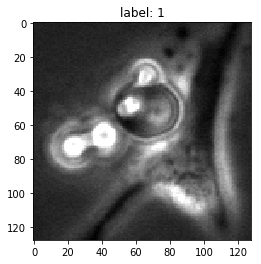

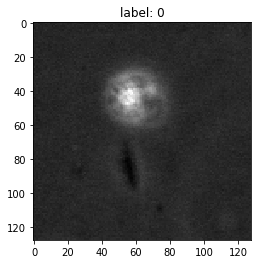

In [11]:
root_path = '../datasets/dataset_cls'
split_list = '../datasets/dataset_cls/split_list/train.txt'

dataset = PreprocessedDataset(root_path, split_list)

# train.txtの0番目の画像とラベルを取得
img, label = dataset.get_example(0)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

# train.txtの80番目の画像とラベルを取得
img, label = dataset.get_example(80)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

画像とラベルが正しい組み合わせで取得できていることが確認できた。

## CNNモデルの定義

画像分類を行うCNNは、畳み込み層と全結合層に分かれている。  
畳み込み層は `L.Convolution2D(in_ch, out_ch, ksize, stride, pad)` ,
全結合層は  `L.Linear(in_ch, out_ch)` のように記述する。  
ここで指定する値は、モデルの構造を決定するパラメータ、すなわちハイパーパラメータと呼ばれる。

```
    in_ch:   入力チャネル数
    out_ch:  出力チャネル数
    ksize:   畳み込みカーネルサイズ
    stride:  カーネルの移動サイズ
    pad:     パディングサイズ
```

また、順伝搬されたデータを正規化するための層を正規化層と呼び、
`L.BatchNormalization(in_ch)` のように記述する。

参考: https://docs.chainer.org/en/stable/reference/links.html

ここまで説明した層 (畳み込み層,  全結合層, 正規化層) はすべてパラメータを持っている。  
一方で、パラメータを持たない、つまり学習によって更新はされない層や関数が存在する。

CNNにおいてよく用いられる次元削減を行うための層としてプーリング層がある。
プーリング層は `F.max_pooling_2d(input, ksize, stride)` のように記述する。
また、代表的な活性化関数としてReLU (Rectified Linear Unit) があり、`F.relu(input)` と記述することができる。

参考: https://docs.chainer.org/en/stable/reference/functions.html

In [12]:
import chainer
import chainer.functions as F
import chainer.links as L

class ClassificationModel(chainer.Chain):
    def __init__(self, n_class=2):
        super(ClassificationModel, self).__init__()
        with self.init_scope():
            # ネットワークの部品 (層) を用意
            self.conv1 = L.Convolution2D(1, 32, 5, 1, 2)
            self.bn1 = L.BatchNormalization(32)
            self.conv2 = L.Convolution2D(32, 64, 5, 1, 2)
            self.bn2 = L.BatchNormalization(64)
            self.conv3 = L.Convolution2D(64, 128, 3, 1, 1)
            self.bn3 = L.BatchNormalization(128)
            self.conv4 = L.Convolution2D(128, 256, 3, 1, 1)
            self.bn4 = L.BatchNormalization(256)
            self.fc5 = L.Linear(16384, 1048)
            self.fc6 = L.Linear(1048, n_class)
            
    def __call__(self, x):
        # 各層を接続
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(self.bn1(h), 2, 2)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(self.bn2(h), 2, 2)
        h = F.relu(self.conv3(h))
        h = F.max_pooling_2d(self.bn3(h), 2, 2)
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(self.bn4(h), 2, 2)
        h = F.dropout(F.relu(self.fc5(h)))
        return self.fc6(h)

## 出力関数

ここまででCNNモデルに用いられる関数と伝搬の仕方を定義したが、最後の出力される層には別の関数を用いる。  
この出力関数を用いることで、問題に応じた値の範囲になるように調節することができる。  
一般的に、分類問題では出力関数に**Softmax**関数が用いられる。

Softmax関数は、$d$次元のベクトル${\bf y} \in \mathbb{R}^d$が与えられたとき、その各次元の値の合計が1になるように正規化することができる。
すなわち、確率分布のような出力となる。
${\bf y}$の$i$番目の次元を$y_i$と書くと，Softmax関数は以下のように定義される。

$$
{\rm Softmax}({\bf y})_i = \frac{\exp(y_i)}{\sum_{j=1}^d \exp(y_j)}
$$

このように表現されるSoftmax関数を出力関数として用いる場合、`F.softmax` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.softmax.html

## CNNモデルによる推論

ここまでで、学習に用いるデータセットとCNNモデルを用意することができた。  
まずはこれらを用いて、実際に画像分類の推論ができるのか試してみる。

In [21]:
import chainer.functions as F
import chainer.links as L

root_path = '../datasets/dataset_cls'
split_list = '../datasets/dataset_cls/split_list/test.txt'

# データセットを用意
test_dataset = PreprocessedDataset(root_path, split_list)

# 未学習のモデルを作成
model = L.Classifier(ClassificationModel(n_class=2))

print('=====================')
for i in range(5):
    with chainer.using_config('train', False):
        # テスト画像とラベルを1セット取得
        img, label = test_dataset.get_example(i)
        # テスト画像の生死を推論
        pred = model.predictor(np.expand_dims(img, axis=0))
        # 出力関数により生・死の確率を求める
        pred = F.softmax(pred)

    print('test {}'.format(i + 1))
    print('  pred: {}'.format(np.argmax(pred.data)))     # 確率が高い方のラベルを表示
    print('  label: {}'.format(label))                                   # 正解のラベルを表示
    print('=====================')

test 1
  pred: 1
  label: 1
test 2
  pred: 0
  label: 1
test 3
  pred: 0
  label: 1
test 4
  pred: 1
  label: 1
test 5
  pred: 0
  label: 1


このように、画像をCNNモデルに入力して、出力された結果から画像分類の推論を確認することができる。  
ただ、このCNNモデルは学習が行われていない状態なので、画像分類の結果もランダムに出力した結果とさほど変わらないことがわかる。  
では次に、すでに用意してある学習済みCNNモデルを使って推論を行なってみる。

In [24]:
import chainer.functions as F
import chainer.links as L
from chainer import serializers

root_path = '../datasets/dataset_cls'
split_list = '../datasets/dataset_cls/split_list/test.txt'
model_path = '../models/inference_model'

# データセットを用意
test_dataset = PreprocessedDataset(root_path, split_list)

# 未学習のモデルを作成
model = L.Classifier(ClassificationModel(n_class=2))

# 学習済みモデルの読み込み
serializers.load_npz(model_path, model)


print('=====================')
for i in range(5):
    with chainer.using_config('train', False):
        # テスト画像とラベルを1セット取得
        img, label = test_dataset.get_example(i)
        # テスト画像の生死を推論
        pred = model.predictor(np.expand_dims(img, axis=0))
        # 出力関数により生・死の確率を求める
        pred = F.softmax(pred)

    print('test {}'.format(i + 1))
    print('  pred: {}'.format(np.argmax(pred.data)))     # 確率が高い方のラベルを表示
    print('  label: {}'.format(label))                                   # 正解のラベルを表示
    print('=====================')

test 1
  pred: 1
  label: 1
test 2
  pred: 0
  label: 1
test 3
  pred: 0
  label: 1
test 4
  pred: 1
  label: 1
test 5
  pred: 0
  label: 1


学習済みモデルを用いた結果、推論結果と正解ラベルがすべて一致していることがわかる。  
では次からは、学習を行うための準備を行なっていく。

## 目的関数

ここでは、上で定義したCNNモデルの目的関数 (誤差関数, 損失関数とも呼ばれる) を定義する。  
目的関数はタスクごとに設定し、分類問題の場合は **Softmax Cross Entropy** 関数を用いるのが一般的である。  
Softmax Cross Entropy関数は、Softmax関数とCross Entropy関数を組み合わせた関数である。

Softmax関数は上述したため、ここではCross Entropy (交差エントロピー) 関数について説明する。
$N$クラスの分類問題の場合、ある入力$x$が与えられたとき、ニューラルネットワークの出力層に$N$個のノードがあり、
それぞれが$n$番目のクラスに属する確率$y_n$を表しているとする。
ここで、$x$が所属するクラスについての正解が、${\bf t} = \begin{bmatrix} t_1 & t_2 & \dots & t_N \end{bmatrix}^T$というベクトルで与えられているとする。
ただし、このベクトルは $t_n (n = 1, 2, \dots, N)$ のいずれか1つだけが1であり、
それ以外は0であるようなベクトル (1-hot ベクトル) であるとする。
そして、この1つだけ値が1となっている要素は、その要素のインデックスに対応したクラスが正解であることを意味する。
このとき、Cross Entropy関数は、以下のように定義される。

$$
{\rm Cross\ Entropy}({\bf y}, {\bf t}) = - \frac{1}{N} \sum_{n=1}^{N}t_{n}\log({\rm Softmax}({\bf y})_{n})
$$

このように表現されるSoftmax Cross Entropy関数を目的関数として用いる場合、`F.softmax_cross_entropy` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.softmax_cross_entropy.html

## CNNモデルの目的関数を定義

ここでは、CNNモデルの出力から目的関数を用いて誤差 (loss) を計算するためのクラスを作成する。

In [25]:
import chainer
import chainer.functions as F
from chainer import reporter, Variable

class Classifier(chainer.Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        # 目的関数を設定
        loss = F.softmax_cross_entropy(y, t)
        # 誤差を記録
        reporter.report({'loss': loss}, self)
        return loss

## 最適化手法

ニューラルネットワークにおける学習は、上述した目的関数を最小化するために最適化を行う必要がある。
この最適化手法は勾配法がベースとなっており、学習時に用いる最適化手法はこれまでに数多く提案されている (参考: https://qiita.com/tokkuman/items/1944c00415d129ca0ee9 )。

Chainerにも多くの最適化手法が実装されているが、今回はその中でも最も用いられている**Adam**という最適化手法を採用する。  
Adamを用いる場合には、`optimizers.Adam` と記述する。

参考: https://docs.chainer.org/en/stable/reference/optimizers.html

## CNNモデルの学習

CNNモデルに目的関数を定義して、最適化手法も決定したため、実際に学習を行なってみる。

In [8]:
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import optimizers, iterators, training

def create_trainer(root_path, train_path, val_path, batchsize, epoch, out='result_cls', device=-1):

    # train データセットを用意
    train_dataset = PreprocessedDataset(root_path, train_path)
    # validation データセットを用意
    val_dataset = PreprocessedDataset(root_path, val_path)
    
    # 
    model = ClassificationModel(n_class=2)
    train_model = Classifier(model)

    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train_dataset, batchsize)
    val_iter = iterators.MultiprocessIterator(val_dataset, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, epoch, out=out)

    logging_attributes = ['epoch', 'main/loss', 'val/main/loss', 'elapsed_time']
    trainer.extend(training.extensions.LogReport(logging_attributes))
    trainer.extend(training.extensions.PrintReport(logging_attributes))
    trainer.extend(training.extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(training.extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(training.extensions.snapshot_object(train_model, filename='best_loss_model'), trigger=training.triggers.MinValueTrigger('val/main/loss', trigger=(1, 'epoch')))
    return trainer


os.makedirs('results', exist_ok=True)
root_path = '../datasets/dataset_cls'
train_path = '../datasets/dataset_cls/split_list/train.txt'
val_path = '../datasets/dataset_cls/split_list/validation.txt'
batchsize = 2
epoch = (20, 'epoch')

trainer = create_trainer(root_path, train_path, val_path, batchsize, epoch, out='results/result_cls_1', device=-1)
trainer.run()

epoch       main/loss   val/main/loss  elapsed_time
1           11.8313     20.7474        64.0517       
2           14.2761     11.5913        132.99        
3           7.61634     21.6883        216.59        
4           10.481      10.3229        286.162       
5           6.35786     7.75682        359.788       
6           3.58781     6.75082        438.301       
7           3.31194     9.1386         523.193       
8           1.91255     9.75951        604.023       
9           3.6707      7.9313         678.677       
10          2.11896     9.89194        752.459       
11          1.43271     6.33591        833.438       
12          0.798359    4.66409        912.982       
13          0.779317    5.31784        990.565       
14          0.715045    9.87527        1063.05       
15          0.860154    8.37648        1133.02       
16          1.21039     7.57281        1209.74       
17          1.39178     15.3082        1283.41       
18          0.508813    8.2844

学習が進むにつれて訓練データの誤差 (`main/loss`) が低下していることがわかる。
つまり、学習が正常に進んでいることがわかる。
このように、lossを継時的に観察することで、学習の進行度を確認することができる。
また、検証データの誤差 (`val/main/loss`) がもっとも低いとき、学習が収束したと判定することができる。
一方で、学習の評価指標が誤差のみだと、実際に画像分類がうまく行われているのか確認することができない。
そこで、学習時に観察する指標を新たに導入することを考える。

## 画像分類精度の評価指標

一般的に、分類問題の精度は**Accuracy**という指標で評価される。Accuracyは全画像のうち何枚の画像を正しく分類できたかを割合で表される指標である。すなわち、Accuracyが高いほど分類精度も高いということになる。 
正解クラスが$i$である画像をCNNモデルがクラス$j$に分類した数を$N_{ij}$とすると、クラス数が$k$のとき、Accuracyは以下のようになる。

$$
{\rm Accuracy} = \frac{\sum_{i=1}^k N_{ii}}{\sum_{i=1}^k \sum_{j=1}^k N_{ij}}
$$

Accuracyを用いる場合、`F.accuracy` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.accuracy.html

In [9]:
import chainer
import chainer.functions as F
from chainer import reporter, Variable

class Classifier(chainer.Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        with chainer.no_backprop_mode():
            accuracy = F.accuracy(y, t)
        reporter.report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

## Accuracyを指標とした学習

先ほどまではlossのみで学習の進行度と収束判定を行なっていたが、今度は導入したAccuracyを用いて同様に学習してみる。

In [10]:
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import optimizers, iterators, training

def create_trainer(root_path, train_path, val_path, batchsize, epoch, out='result_cls', device=-1):

    train_dataset = PreprocessedDataset(root_path, train_path)
    val_dataset = PreprocessedDataset(root_path, val_path)
    
    model = ClassificationModel(n_class=2)
    train_model = Classifier(model)

    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train_dataset, batchsize)
    val_iter = iterators.MultiprocessIterator(val_dataset, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, epoch, out=out)

    logging_attributes = ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']
    trainer.extend(training.extensions.LogReport(logging_attributes))
    trainer.extend(training.extensions.PrintReport(logging_attributes))
    trainer.extend(training.extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(training.extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(training.extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(training.extensions.snapshot_object(train_model, filename='best_acc_model'), trigger=training.triggers.MaxValueTrigger('val/main/accuracy', trigger=(1, 'epoch')))
    return trainer


root_path = '../datasets/dataset_cls'
train_path = '../datasets/dataset_cls/split_list/train.txt'
val_path = '../datasets/dataset_cls/split_list/validation.txt'
batchsize = 2
epoch = (20, 'epoch')

trainer = create_trainer(root_path, train_path, val_path, batchsize, epoch, out='results/result_cls_2', device=-1)
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           13.6053     0.64375        18.7004        0.675              66.5345       
2           14.7703     0.60625        54.9272        0.4                132.285       
3           18.891      0.625          9.78768        0.625              197.732       
4           11.4957     0.68125        9.85059        0.525              259.055       
5           10.355      0.63125        9.68522        0.6                320.19        
6           5.51144     0.73125        16.535         0.65               381.526       
7           3.37009     0.8            9.26117        0.7                442.782       
8           3.32845     0.78125        14.0912        0.55               507.249       
9           2.76573     0.8125         7.27151        0.625              568.635       
10          1.98841     0.825          10.1923        0.475              628.911       
11          1.44695     0.8625    

## テストデータを用いた画像分類の精度

In [11]:
import numpy as np
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import serializers

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):
    test_dataset = PreprocessedDataset(root_path, test_path)
    
    model = ClassificationModel(n_class=2)
    train_model = Classifier(model)
    serializers.load_npz(model_path, train_model)
    
    true_conut = 0
    for i in range(test_dataset.__len__()):
        with chainer.using_config('train', False):
            x, t = test_dataset.get_example(i)
            y = train_model.predictor(np.expand_dims(x, axis=0))
        if np.argmax(y.data) == t:
            true_conut += 1
    accuracy = true_conut / test_dataset.__len__()
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
    print('accuracy: {}'.format(accuracy))
    
    
root_path = '../datasets/dataset_cls'
test_path = '../datasets/dataset_cls/split_list/test.txt'

model_path = 'results/result_cls_1/best_loss_model'
test(root_path, test_path, model_path, 'results/result_cls_1_test', device=-1)

model_path = 'results/result_cls_2/best_acc_model'
test(root_path, test_path, model_path, 'results/result_cls_2_test', device=-1)

accuracy: 0.61
accuracy: 0.65


## 5分割交差検証 (5-fold cross validation)

交差検証とは、

## fold 1

In [12]:
root_path = '../datasets/dataset_cls'
batchsize = 2
epoch = (20, 'epoch')

train_path_fold1 = '../datasets/dataset_cls/split_list/fold1/train.txt'
val_path_fold1 = '../datasets/dataset_cls/split_list/fold1/validation.txt'

trainer_fold1 = create_trainer(root_path, train_path_fold1, val_path_fold1, batchsize, epoch=epoch, out='results/result_cls_fold1', device=-1)
trainer_fold1.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           16.1242     0.5125         16.1115        0.475              62.8336       
2           11.1063     0.6625         17.2855        0.525              126.604       
3           11.3524     0.66875        12.0311        0.475              190.071       
4           9.78012     0.66875        27.757         0.575              251.212       
5           11.5238     0.65625        17.1304        0.55               319.301       
6           5.38705     0.8125         16.1497        0.5                386.988       
7           6.17033     0.75625        22.8763        0.575              450.675       
8           3.27017     0.875          16.0004        0.65               518.374       
9           2.18491     0.9            13.8526        0.625              595.294       
10          3.10988     0.89375        50.9595        0.55               663.997       
11          3.17251     0.88125   

## fold 2

In [13]:
train_path_fold2 = '../datasets/dataset_cls/split_list/fold2/train.txt'
val_path_fold2 = '../datasets/dataset_cls/split_list/fold2/validation.txt'

trainer_fold2 = create_trainer(root_path, train_path_fold2, val_path_fold2, batchsize, epoch=epoch, out='results/result_cls_fold2', device=-1)
trainer_fold2.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           15.4598     0.51875        12.4746        0.65               60.6149       
2           15.1709     0.59375        36.5993        0.525              124.063       
3           17.0638     0.575          22.9563        0.45               187.937       
4           14.4523     0.55625        4.60048        0.7                247.819       
5           5.27429     0.6875         5.4564         0.7                311.168       
6           3.72888     0.75625        6.28491        0.65               371.387       
7           4.32562     0.7375         8.21535        0.5                431.366       
8           3.42009     0.7625         13.3665        0.525              492.003       
9           4.40153     0.70625        10.7457        0.525              552.127       
10          3.13209     0.80625        5.41327        0.625              612.395       
11          2.29423     0.825     

## fold 3

In [14]:
train_path_fold3 = '../datasets/dataset_cls/split_list/fold3/train.txt'
val_path_fold3 = '../datasets/dataset_cls/split_list/fold3/validation.txt'

trainer_fold3 = create_trainer(root_path, train_path_fold3, val_path_fold3, batchsize, epoch=epoch, out='results/result_cls_fold3', device=-1)
trainer_fold3.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           13.8562     0.53125        15.7366        0.55               60.5785       
2           13.1732     0.575          13.5258        0.525              124.643       
3           10.7863     0.525          9.62699        0.6                185.013       
4           8.08838     0.625          7.34154        0.575              248.719       
5           5.96147     0.6875         9.12238        0.45               309.051       
6           5.07407     0.7            3.45034        0.75               369.111       
7           3.16333     0.75625        4.08752        0.725              432.736       
8           3.68786     0.68125        2.77009        0.675              493.057       
9           2.44973     0.75           5.37493        0.475              553.44        
10          1.88905     0.75           3.59244        0.7                613.726       
11          1.13279     0.80625   

## fold 4

In [15]:
train_path_fold4 = '../datasets/dataset_cls/split_list/fold4/train.txt'
val_path_fold4 = '../datasets/dataset_cls/split_list/fold4/validation.txt'

trainer_fold4 = create_trainer(root_path, train_path_fold4, val_path_fold4, batchsize, epoch=epoch, out='results/result_cls_fold4', device=-1)
trainer_fold4.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           16.1127     0.4875         16.1292        0.575              60.3809       
2           14.5925     0.5125         26.3864        0.425              124.445       
3           10.7052     0.575          4.76245        0.725              187.575       
4           5.31016     0.69375        4.57949        0.625              251.368       
5           4.18665     0.7            1.60865        0.775              312.254       
6           2.65481     0.71875        4.14508        0.65               376.065       
7           2.92373     0.7625         3.11763        0.6                436.552       
8           1.52152     0.85625        3.61894        0.575              497.082       
9           1.76448     0.80625        2.74491        0.7                557.594       
10          2.73539     0.75625        2.39045        0.6                617.934       
11          1.26867     0.85625   

## fold 5

In [16]:
train_path_fold5 = '../datasets/dataset_cls/split_list/fold5/train.txt'
val_path_fold5 = '../datasets/dataset_cls/split_list/fold5/validation.txt'

trainer_fold5 = create_trainer(root_path, train_path_fold5, val_path_fold5, batchsize, epoch=epoch, out='results/result_cls_fold5', device=-1)
trainer_fold5.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           15.9185     0.55625        17.5284        0.45               60.7391       
2           13.3868     0.625          17.2013        0.4                124.339       
3           12.7777     0.63125        14.5061        0.7                186.159       
4           11.1167     0.66875        37.3296        0.45               249.635       
5           10.7655     0.6375         11.5175        0.525              311.79        
6           4.54051     0.7625         12.7787        0.625              374.064       
7           3.19515     0.75625        16.7259        0.55               434.477       
8           3.22828     0.80625        10.9398        0.55               495.274       
9           1.52471     0.85625        10.7115        0.6                557.874       
10          1.83445     0.8375         19.8252        0.625              618.285       
11          1.75744     0.8875    

## Cross Validationの評価

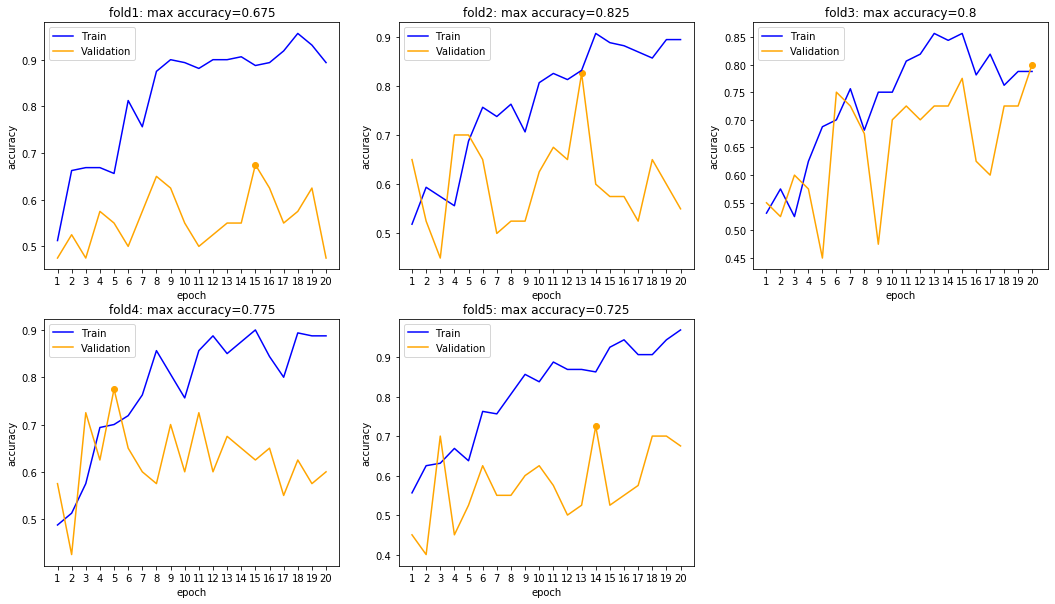

In [17]:
import os
import glob
import json
import matplotlib.pylab as plt

res_cv_path = glob.glob('results/result_cls_fold*')
res_log = []
for cv in res_cv_path:
    with open(os.path.join(cv, 'log'), 'r') as f:
        res_log.append(json.load(f))


%matplotlib inline
    
plt.figure(figsize=(18, 10))
for k in range(len(res_log)):
    train, val, epoch = [], [], []
    for n in range(len(res_log[k])):
        train.append(res_log[k][n]['main/accuracy'])
        val.append(res_log[k][n]['val/main/accuracy'])
        epoch.append(res_log[k][n]['epoch'])
    plt.subplot(2, 3, k+1)
    plt.plot(epoch, train, label='Train', color='blue')
    plt.plot(epoch, val, label='Validation', color='orange')
    plt.scatter(np.argmax(val)+1, np.max(val), marker='o', color='orange')
    plt.xticks(epoch)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('fold{}: max accuracy={}'.format(k+1, np.max(val)))
    plt.legend()

## テスト関数の作成

In [18]:
import numpy as np
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import serializers

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):
    test_dataset = PreprocessedDataset(root_path, test_path)
    
    model = ClassificationModel(n_class=2)
    train_model = Classifier(model)
    serializers.load_npz(model_path, train_model)
    
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(test_dataset.__len__()):
        with chainer.using_config('train', False):
            x, t = test_dataset.get_example(i)
            y = train_model.predictor(np.expand_dims(x, axis=0))
        if np.argmax(y.data) == t:
            if t == 1:
                tp += 1
            else:
                tn += 1
        else:
            if t == 1:
                fn += 1
            else:
                fp += 1
            
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = 2 * precision * recall / (precision + recall)
    
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
        f.write('precision: {}\n'.format(precision))
        f.write('recall: {}\n'.format(recall))
        f.write('f-score: {}\n'.format(fscore))
    print('accuracy: {}'.format(accuracy))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('f-score: {}'.format(fscore))

## テスト

In [20]:
root_path = '../datasets/dataset_cls'
test_path = '../datasets/dataset_cls/split_list/test.txt'
model_path = 'results/result_cls_fold2/best_acc_model'

test(root_path, test_path, model_path, 'results/result_cls_test', device=-1)

accuracy: 0.71
precision: 0.6842105263157895
recall: 0.78
f-score: 0.7289719626168225
